# Introducción a la solución en diferencias finitas de PDEs

## Estabilidad y condicion CFL

En este cuaderno, exploraremos de que forma el cambio en los parametros de discretizacion puede afectar nuestra solucion numerica.

En primer lugar, experimentamos con el numero de puntos en la grilla. El siguiente codigo corresponde al caso de adveccion lineal, escrito en una funcion de modo que podamos examinar facilemente que sucede a medida que modificamos solo una variable: **el tamaño de grilla**.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
def linear_convection(nx,L=2.0,c=1.0,dt=0.025,nt=20):
    """
    Solves the 1D linear convection equation
    with constant speed c in the domain [0,L]
    and plots the solution (along with the initial conditions).

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Convection speed; default: 1.0.
    dt : float, optional
        Time-step size; default: 0.025.
    nt : integer, optional
        Number of time steps to compute; default: 20.
    """
    # Discretize spatial grid
    dx = L/(nx-1)
    x = numpy.linspace(0.0,L,num=nx)
    # Set initial conditions
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    # Integrate the solution in time
    u = u0.copy()
    for n in range(1,nt):
        u[1:] = u[1:] - c*dt/dx*(u[1:]-u[:-1])
    # Plot the solution along with the initial conditions
    pyplot.figure(figsize=(4.0,4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x,u0,label='Initial',
                color='C0',linestyle='--',linewidth=2)
    pyplot.plot(x,u,label='nt = {}'.format(nt),
                color='C1',linestyle='-',linewidth=2)
    pyplot.legend()
    pyplot.xlim(0.0,L)
    pyplot.ylim(0.0,2.5);

Examinemos los resultados del problema de conveccion lineal obtenidos al incrementar la resolucion espacial de la grilla (esto es, empleando grillas cada vez mas finas). Probaremos con 41, 61, 71, 85 puntos:

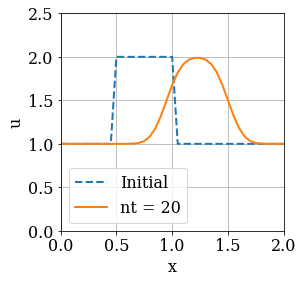

In [5]:
linear_convection(41)  # solve using 41 spatial grid points

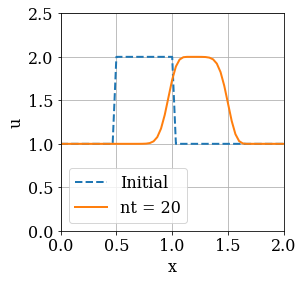

In [6]:
linear_convection(61)

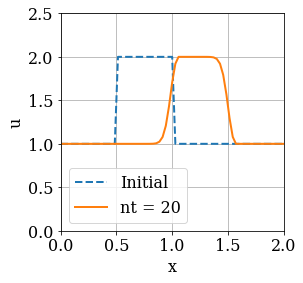

In [7]:
linear_convection(71)

Hasta aqui todo bien! A medida que refinamos la grilla espacial, la onda es mas cuadrada, lo cual indica una disminucion del error de discretizacion. Pero que sucede si refinamos aun mas la grilla? Probemos con 85 puntos:

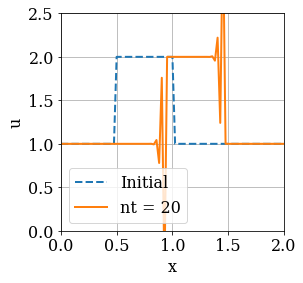

In [7]:
linear_convection(85)

<div class="alert alert-block alert-danger">
<h3>What happened?</h3>
</div>

<div class="alert alert-block alert-success">
In each iteration of the time loop, we use the existing data about the solution at time $n$ to compute the solution in the subsequent time step, $n+1$.  In the first few cases, the increase in the number of grid points returned more accurate results.  There was less discretization error and the translating wave looked more like a square wave than it did in our first example.  

Each iteration of the time loop advances the solution by a time-step of length $\Delta t$, which had the value 0.025 in the examples above. During this iteration, we evaluate the solution $u$ at each of the $x_i$ points on the grid.  But in the last plot, something has clearly gone wrong.  

What has happened is that over the time period $\Delta t$, the wave is travelling a distance which is greater than `dx`, and we say that the solution becomes *unstable* in this situation. The length `dx` of grid spacing is inversely proportional to the number of total points `nx`: we asked for more grid points, so `dx` got smaller. Once `dx` got smaller than the $c\Delta t$—the distance travelled by the numerical solution in one time step—it's no longer possible for the numerical scheme to solve the equation correctly!
</div>

![CFLcondition](./figuras/CFLcondition.png)

<div class="alert alert-block alert-warning">
Consider the illustration above. The green triangle represents the <b>domain of dependence</b> of the numerical scheme. Indeed, for each time step, the variable $u_i^{n+1}$ only depends on the values $u_i^{n}$ and $u_{i-1}^{n}$. 

When the distance $c\Delta t$ is smaller than $\Delta x$, the characteristic line traced from the grid coordinate $(i, n+1)$ lands between the points $(i-1,n)$ and $(i,n)$ on the grid. We then say that the mathematical <b>domain of dependence</b> of the solution of the original PDE is contained in the <b>domain of dependence</b> of the numerical scheme. 

On the contrary, if $\Delta x$ is smaller than $c\Delta t$, then the information about the solution needed for $u_i^{n+1}$ is not available in the <b>domain of dependence</b> of the numerical scheme, because the characteristic line traced from the grid coordinate $(i,n+1)$ lands behind the point $(i-1,n)$ on the grid. 

The following condition thus ensures that the domain of dependence of the differential equation is contained in the <i>numerical</i> domain of dependence: 

$$
\begin{equation}
\sigma = \frac{c \Delta t}{\Delta x} \leq 1
\end{equation}
$$

As can be proven formally, stability of the numerical solution requires that step size `dt` is calculated with respect to the size of `dx` to satisfy the condition above.  

The value of $c\Delta t/\Delta x$ is called the **Courant-Friedrichs-Lewy number** (CFL number), often denoted by $\sigma$. The value $\sigma_{\text{max}}$ that will ensure stability depends on the discretization used; for the forward-time/backward-space scheme, the condition for stability is $\sigma<1$.
</div>   

In [9]:
def linear_convection_cfl(nx,L=2.0,c=1.0,sigma=0.5,nt=20):
    """
    Solves the 1D linear convection equation
    with constant speed c in the domain [0,L]
    and plots the solution (along with the initial conditions).
    Here, the time-step size is calculated based on a CFL constraint.

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Convection speed; default: 1.0.
    sigma : float, optional
        CFL constraint; default: 0.5.
    dt : float, optional
        Time-step size; default: 0.025.
    nt : integer, optional
        Number of time steps to compute; default: 20.
    """
    # Discretize spatial grid
    dx = L/(nx-1)
    x = numpy.linspace(0.0,L,num=nx)
    # Compute the time-step size based on the CFL constraint
    dt = sigma*dx/c
    # Set initial conditions
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    # Integrate the solution in time
    u = u0.copy()
    for n in range(1, nt):
        u[1:] = u[1:] -c*dt/dx*(u[1:]-u[:-1])
    # Plot the solution along with the initial conditions
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x,u0,label='Initial',
                color='C0',linestyle='--',linewidth=2)
    pyplot.plot(x,u,label='nt = {}'.format(nt),
                color='C1',linestyle='-',linewidth=2)
    pyplot.legend()
    pyplot.xlim(0.0,L)
    pyplot.ylim(0.0,2.5);

Ahora, no importa cuantos puntos usemos para la grilla espacial: la solucion sera siempre estable!

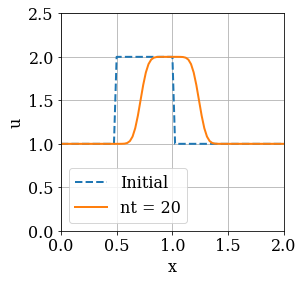

In [9]:
linear_convection_cfl(85)

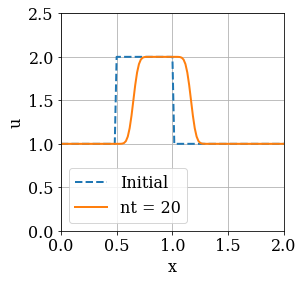

In [10]:
linear_convection_cfl(121)

Notamos que a medida que aumenta el numero de puntos `nx`, la onda se desplaza (*convecta*) una distancia cada vez menor.

En efecto, al refinar la malla disminuye `dx`, y en consecuencia para satisfacer la condicion CFL disminuye `dt`. Puesto que el numero de pasos de tiempo empleados para avanzar la solucion se ha mantenido constante (`nt=20`), disminuira el periodo de tiempo $\Delta t$; esto es, se reducira el tamaño de la ventana temporal que esta siendo examinada.

###### The cell below loads the style of the notebook.

In [2]:
from IPython.core.display import HTML
css_file = '.././styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())